# PSTAT 135: Big Data Analytics

Group 22: Jia Nie, Ryan Sevilla, Sammy Suliman, Zini Wang

# Table of Contents

- [Introduction](#Introduction)
- [Research Question](#Research-Question)
- [Data Cleaning and Exploration](#Data-Cleaning-and-Exploration)
- [Data Analysis](#Data-Analysis)
  - [Location](#Location)
  - [Ethnicity](#Ethnicity)
  - [Income / Wealth](#Income/Wealth)
- [Conclusion](#Conclusion)
- [Recommendations for Political Campaign](#Recommendations-for-Political-Campaign)

## Introduction

This report aims to explore the factors influencing voter turnout in the United States.The analysis centers on voter files, detailed datasets capturing geographic, demographic, and voting activity of U.S. registered voters. We utilize advanced data analytics, including statistical analysis and predictive modeling, to read these files and explore voting disparities among various demographics. Our focus is to identify key factors influencing voter turnout—specifically, socioeconomic status, age, ethnicity, and voting location accessibility. 


## Research Question

How does voter income, age, ethnicity, and location individually impact voter turnout, and which of these factors is most important?

Understanding how voter income, age, ethnicity, and location impact voter turnout is vital for ensuring equitable democratic participation and identifying systemic barriers to voting. This inquiry highlights disparities in political engagement, guiding efforts to enhance representation and inclusivity in the electoral process.

In [170]:
# Import necessary libraries
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import re

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, length, desc, avg, sum as pyspark_sum, isnan, when, col, round, concat, upper, regexp_replace, coalesce, split
from pyspark.sql.types import StringType, IntegerType, DoubleType, BooleanType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [168]:
spark = SparkSession \
.builder \
.appName("Read Voter File Data") \
.getOrCreate()

df = (
spark.read
.format("parquet")
.option("header", "true")
.option("inferSchema", "true")
.load("gs://winter-2024-voter-file/VM2Uniform/VM2Uniform--WY--2021-01-13")
)

## Data Cleaning and Exploration

In [3]:
executor_memory = spark.sparkContext.getConf().get("spark.executor.memory")
driver_memory = spark.sparkContext.getConf().get("spark.driver.memory")

Let's see how much memory is contained within the spark cluster

In [4]:
print(executor_memory)

6157m


In [5]:
print(driver_memory)

4096m


In [6]:
col_list = df.columns

We want to replace county names, which are prone to repetition across state lines, with their FIPS code, which is unique to each county.

In [8]:
counties = (
spark.read
.format("csv")
.option("header", "true")
.option("inferSchema", "true")
.load("gs://winter-2024-voter-file/uscounties.csv")
)

In [9]:
df.select("County").show(5)

+------+
|County|
+------+
|ALBANY|
|ALBANY|
|ALBANY|
|ALBANY|
|ALBANY|
+------+
only showing top 5 rows



In [10]:
counties = counties.drop('county_ascii', 'county_full', 'state_name', 'lat', 'lng', 'population')
print(counties.limit(10).toPandas())

        county  county_fips state_id
0  Los Angeles         6037       CA
1         Cook        17031       IL
2       Harris        48201       TX
3     Maricopa         4013       AZ
4    San Diego         6073       CA
5       Orange         6059       CA
6   Miami-Dade        12086       FL
7       Dallas        48113       TX
8        Kings        36047       NY
9    Riverside         6065       CA


In [11]:
counties = counties.withColumn("county", upper(col("county")))
print(counties.limit(10).toPandas())

        county  county_fips state_id
0  LOS ANGELES         6037       CA
1         COOK        17031       IL
2       HARRIS        48201       TX
3     MARICOPA         4013       AZ
4    SAN DIEGO         6073       CA
5       ORANGE         6059       CA
6   MIAMI-DADE        12086       FL
7       DALLAS        48113       TX
8        KINGS        36047       NY
9    RIVERSIDE         6065       CA


In [12]:
counties = counties.withColumnRenamed("county", "County")
print(counties.limit(10).toPandas())

        County  county_fips state_id
0  LOS ANGELES         6037       CA
1         COOK        17031       IL
2       HARRIS        48201       TX
3     MARICOPA         4013       AZ
4    SAN DIEGO         6073       CA
5       ORANGE         6059       CA
6   MIAMI-DADE        12086       FL
7       DALLAS        48113       TX
8        KINGS        36047       NY
9    RIVERSIDE         6065       CA


In [13]:
counties = counties.withColumn("full_county", concat(col("County"), col("state_id")))
print(counties.limit(10).toPandas())

        County  county_fips state_id    full_county
0  LOS ANGELES         6037       CA  LOS ANGELESCA
1         COOK        17031       IL         COOKIL
2       HARRIS        48201       TX       HARRISTX
3     MARICOPA         4013       AZ     MARICOPAAZ
4    SAN DIEGO         6073       CA    SAN DIEGOCA
5       ORANGE         6059       CA       ORANGECA
6   MIAMI-DADE        12086       FL   MIAMI-DADEFL
7       DALLAS        48113       TX       DALLASTX
8        KINGS        36047       NY        KINGSNY
9    RIVERSIDE         6065       CA    RIVERSIDECA


In [14]:
df = df.withColumn("full_county", concat(col("County"), col("Residence_Addresses_State")));

In [15]:
df2 = df.join(counties, "full_county", "inner")

In [16]:
# drop duplicate column 'County'
df2 = df2.drop('County')

After looking at the description of each column of the dataframe provided, we notice that some columns have false nulls that is some columns have values yes/null where null really means "no". We want to fill in these false nulls to avoid accidentally dropping columns with enough data in the next step.

In [17]:
columns_to_fill = ["CommercialDataLL_Business_Owner","CommercialDataLL_Buyer_Antiques_In_Household","CommercialDataLL_Buyer_Art_In_Household","CommercialDataLL_Collector_Antiques_In_Household","CommercialDataLL_Collector_Arts_In_Household","CommercialDataLL_Collector_Avid_In_Household",
"CommercialDataLL_Collector_Coins_In_Household","CommercialDataLL_Collector_General_In_Household","CommercialDataLL_Collector_Military_In_Household","CommercialDataLL_Collector_Sports_In_Household","CommercialDataLL_Collector_Stamps_In_Household","CommercialDataLL_Donates_to_Animal_Welfare","CommercialDataLL_Donates_to_Arts_and_Culture","CommercialDataLL_Donates_to_Childrens_Causes",
"CommercialDataLL_Donates_to_Conservative_Causes","CommercialDataLL_Donates_to_Healthcare","CommercialDataLL_Donates_to_International_Aid_Causes","CommercialDataLL_Donates_to_Liberal_Causes","CommercialDataLL_Donates_to_Local_Community","CommercialDataLL_Donates_to_Veterans_Causes",
"CommercialDataLL_Donates_to_Wildlife_Preservation","CommercialDataLL_Home_Office","CommercialDataLL_Home_Owner_Or_Renter","CommercialDataLL_Interest_in_Auto_Work_In_Household","CommercialDataLL_Interest_in_Automotive_Parts_Accessories_In_Household","CommercialDataLL_Interest_in_Aviation_In_Household","CommercialDataLL_Interest_in_BoardGames_Puzzles_In_Household",
"CommercialDataLL_Interest_in_Boating_Sailing_In_Household","CommercialDataLL_Interest_in_Camping_Hiking_In_Household","CommercialDataLL_Interest_in_Cooking_General_In_Household","CommercialDataLL_Interest_in_Cooking_Gourmet_In_Household","CommercialDataLL_Interest_in_Crafts_In_Household","CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household","CommercialDataLL_Interest_in_Education_Online_In_Household",
"CommercialDataLL_Interest_in_Electronic_Gaming_In_Household","CommercialDataLL_Interest_in_Exercise_Aerobic_In_Household","CommercialDataLL_Interest_in_Exercise_Health_In_Household","CommercialDataLL_Interest_in_Exercise_Running_Jogging_In_Household","CommercialDataLL_Interest_in_Exercise_Walking_In_Household","CommercialDataLL_Interest_in_Fishing_In_Household",
"CommercialDataLL_Interest_in_Food_Wines_In_Household","CommercialDataLL_Interest_in_Foods_Natural_In_Household","CommercialDataLL_Interest_in_Gaming_Casino_In_Household","CommercialDataLL_Interest_in_Gardening_In_Household","CommercialDataLL_Interest_in_Golf_In_Household","CommercialDataLL_Interest_in_History_Military_In_Household","CommercialDataLL_Interest_in_Home_Furnishings_In_Household","CommercialDataLL_Interest_in_Home_Improvement_In_Household","CommercialDataLL_Interest_in_Home_Repair_In_Household",
"CommercialDataLL_Interest_in_House_Plants_In_Household","CommercialDataLL_Interest_in_Hunting_In_Household","CommercialDataLL_Interest_in_Motorcycling_In_Household","CommercialDataLL_Interest_in_Musical_Instruments_In_Household","CommercialDataLL_Interest_in_Nascar_In_Household","CommercialDataLL_Interest_in_Photography_In_Household","CommercialDataLL_Interest_in_Photography_Video_In_Household","CommercialDataLL_Interest_in_Religious_Inspirational_In_Household","CommercialDataLL_Interest_in_Science_Space_In_Household","CommercialDataLL_Interest_in_Scuba_Diving_In_Household","CommercialDataLL_Interest_in_Sewing_Knitting_In_Household",
"CommercialDataLL_Interest_in_Shooting_In_Household","CommercialDataLL_Interest_in_Smoking_In_Household","CommercialDataLL_Interest_in_Snow_Skiing_In_Household","CommercialDataLL_Interest_in_SpectatorSports_Auto_Racing_In_Household","CommercialDataLL_Interest_in_SpectatorSports_Baseball_In_Household","CommercialDataLL_Interest_in_SpectatorSports_Basketball_In_Household","CommercialDataLL_Interest_in_SpectatorSports_Football_In_Household","CommercialDataLL_Interest_in_SpectatorSports_Hockey_In_Household",
"CommercialDataLL_Interest_in_SpectatorSports_on_TV_In_Household","CommercialDataLL_Interest_in_SpectatorSports_Soccer_In_Household","CommercialDataLL_Interest_in_Sports_Leisure_In_Household","CommercialDataLL_Interest_in_Sweepstakes_Contests_In_Household","CommercialDataLL_Interest_in_Tennis_In_Household","CommercialDataLL_Interest_in_the_Arts_In_Household","CommercialDataLL_Interest_in_Theater_Performing_Arts_In_Household","CommercialDataLL_Interest_in_Travel_Cruise_In_Household",
"CommercialDataLL_Interest_in_Travel_Domestic_In_Household","CommercialDataLL_Interest_in_Travel_International_In_Household","CommercialDataLL_Interest_in_Woodworking_In_Household","CommercialDataLL_Investor","CommercialDataLL_HH_Net_Worth","CommercialDataLL_PetOwner_Cat","CommercialDataLL_PetOwner_Dog","CommercialDataLL_PetOwner_Horse","CommercialDataLL_PetOwner_Other","CommercialDataLL_Veteran"]

In [18]:
df_2 = df2.na.fill(value='No', subset=columns_to_fill)

We now will drop all columns with a certain percentage of missing values, setting the threshhold to 40%

In [19]:
def find_column_missing_percentage(df):
    """
    This function takes a PySpark DataFrame as input and returns a DataFrame after adding 
    columns that have missing values and the percentage of missing values in each column.

    :param df: PySpark DataFrame
    :return: PySpark DataFrame with percentage missing in each column
    """
    # Calculate the total number of rows
    total_rows = df.count()

    # Initialize an empty dictionary to store missing percentages for each column
    column_missing_percentages = {}

    # Iterate over each column
    for column_name in df.columns:
        # Calculate the count of missing values in the column
        missing_count = df.where(col(column_name).isNull() | isnan(col(column_name))).count()
        
        # Calculate the percentage of missing values for the column
        percent_missing = (missing_count / total_rows) * 100

        # Round the percentage to two decimal places
     #   percent_missing = round(percent_missing, 2)

        # Store the percentage in the dictionary
        column_missing_percentages[column_name] = percent_missing

    # Create a DataFrame with the missing percentages for each column
    column_missing_df = spark.createDataFrame([(column, percentage) for column, percentage in column_missing_percentages.items()], ["column", "percent_missing"])

    return column_missing_df

In [21]:
# Execute/calling the function
column_missing_df = find_column_missing_percentage(df2)

In [22]:
print(column_missing_df.limit(10).toPandas())

                                column  percent_missing
0                          full_county         0.000000
1                             SEQUENCE         0.000000
2                           LALVOTERID         0.000000
3                        Voters_Active         0.000000
4                  Voters_StateVoterID         0.000000
5                 Voters_CountyVoterID       100.000000
6     VoterTelephones_LandlineAreaCode        74.126216
7       VoterTelephones_Landline7Digit        74.126216
8    VoterTelephones_LandlineFormatted        74.126216
9  VoterTelephones_LandlineUnformatted        74.126216


In [23]:
filtered_df = column_missing_df.filter(column_missing_df["percent_missing"] > 40)

In [24]:
missing_cols = filtered_df.select('column')

In [25]:
print(len(filtered_df.toPandas()))

484


In [26]:
values_list = [row[0] for row in missing_cols.collect()]

In [27]:
df3 = df2.alias('df3')
for missing_col in values_list:
    df3 = df3.drop(missing_col)

It looks like many of the columns in our dataset were riddled with missing values, we dropped 484 columns total.

In [28]:
print(len(df3.columns))

244


Additionally, after careful perusal of our dataset, we see many of the columns are repeated copies of others and therefore should be dropped for computational efficiency

In [29]:
names_to_drop = ['Residence_Address_AddressLine', 'Mailing_Address_AddressLine', 'ElectionReturns_G08_Cnty_Pct_McCain_R',
                'ElectionReturns_G08_Cnty_Pct_Obama_D', 'ElectionReturns_G12_Cnty_Pct_Romney_R', 
                 'ElectionReturns_G12_Cnty_Pct_Obama_D', 'ElectionReturns_G16_Cnty_Pct_Clinton_D',
                'ElectionReturns_G16_Cnty_Pct_Trump_R', 'ElectionReturns_P08_Cnty_Pct_Obama_D',
                'ElectionReturns_P08_Cnty_Pct_Clinton_D', 'ElectionReturns_P12_Cnty_Pct_Gingrich_R',
                 'ElectionReturns_P12_Cnty_Pct_Paul_R',
                'ElectionReturns_P12_Cnty_Pct_Romney_R', 'ElectionReturns_P12_Cnty_Pct_Santorum_R',
                'ElectionReturns_P16_Cnty_Pct_Bush_R', 'ElectionReturns_P16_Cnty_Pct_Carson_R', 
                'ElectionReturns_P16_Cnty_Pct_Christie_R', 'ElectionReturns_P16_Cnty_Pct_Cruz_R', 
                'ElectionReturns_P16_Cnty_Pct_Fiorina_R', 'ElectionReturns_P16_Cnty_Pct_Kasich_R', 
                'ElectionReturns_P16_Cnty_Pct_Rubio_R', 'ElectionReturns_P16_Cnty_Pct_Trump_R', 
                'ElectionReturns_P16_Cnty_Pct_Clinton_D', 'ElectionReturns_P16_Cnty_Pct_Sanders_D']
df4 = df3.alias('df4')
for col_name in names_to_drop:
    df3 = df3.drop(col_name)

We will save our dataset to a csv file within our bucket so that we can use it in other notebooks and additionally reload this notebook quicker without having to rerun previous cells.

In [66]:
df3.write\
    .format("csv")\
    .option("header","true")\
    .save("gs://final-project-bucket-135/df3_2")

In [30]:
print(len(df3.columns))

228


## Data Analysis

### Location

We want to see the impact of location on turnout rates. To do this we will plot turnout rates aggregated over individual counties over the most recent US counties to see which regions of the state are associated with higher turnout and some potential causes of this.

In [31]:
county_pct = df3.select('full_county', 'ElectionReturns_G08CountyTurnoutAllRegisteredVoters',
                        'ElectionReturns_G10CountyTurnoutAllRegisteredVoters',
                        'ElectionReturns_G12CountyTurnoutAllRegisteredVoters',
                        'ElectionReturns_G14CountyTurnoutAllRegisteredVoters',
                        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters',
                        'ElectionReturns_G18CountyTurnoutAllRegisteredVoters')

In [33]:
county_pct_2 = county_pct.dropDuplicates()

In [34]:
county_pct_3 = county_pct_2.withColumnRenamed('ElectionReturns_G08CountyTurnoutAllRegisteredVoters', '2008').withColumnRenamed('ElectionReturns_G10CountyTurnoutAllRegisteredVoters', '2010').withColumnRenamed('ElectionReturns_G12CountyTurnoutAllRegisteredVoters', '2012').withColumnRenamed('ElectionReturns_G14CountyTurnoutAllRegisteredVoters', '2014').withColumnRenamed('ElectionReturns_G16CountyTurnoutAllRegisteredVoters', '2016').withColumnRenamed('ElectionReturns_G18CountyTurnoutAllRegisteredVoters', '2018')
county_pct_3.show(10)

+-------------+----+----+----+----+----+----+
|  full_county|2008|2010|2012|2014|2016|2018|
+-------------+----+----+----+----+----+----+
|     ALBANYWY| 76%| 64%| 73%| 60%| 77%| 97%|
|    LARAMIEWY| 72%| 69%| 69%| 63%| 71%| 94%|
|   BIG HORNWY| 72%| 75%| 72%| 72%| 73%| 91%|
|     CARBONWY| 68%| 71%| 64%| 67%| 63%| 93%|
|HOT SPRINGSWY| 84%| 81%| 83%| 73%| 87%| 95%|
|   CONVERSEWY| 74%| 73%| 73%| 65%| 77%| 92%|
|    JOHNSONWY| 80%| 79%| 78%| 71%| 81%| 92%|
|    FREMONTWY| 70%| 76%| 68%| 70%| 68%| 94%|
|      CROOKWY| 84%| 80%| 84%| 69%| 87%| 91%|
|   CAMPBELLWY| 59%| 65%| 63%| 59%| 66%| 94%|
+-------------+----+----+----+----+----+----+
only showing top 10 rows



In [35]:
county_pct_4 = county_pct_3.toPandas()

In [36]:
def percent_to_decimal(percent):
    percent2 = percent[0:-1]
    return float('0.' + percent2)

In [38]:
year_list = ['2008', '2010', '2012', '2014', '2016', '2018']
line_list = []
for i in range(23):    
    test_plot_df = county_pct_4.loc[i]

    test_plot_df.columns = test_plot_df.iloc[0]

    # Drop the first row
    test_plot_df = test_plot_df.drop(test_plot_df.index[0])

    # Reset the index
    test_plot_df = test_plot_df.reset_index(drop=True)

    test_plot_df = test_plot_df.apply(percent_to_decimal)

    plot_list = test_plot_df.values.tolist()
    line_list.append(plot_list)

In [39]:
county_list = county_pct_4.full_county.values.tolist()

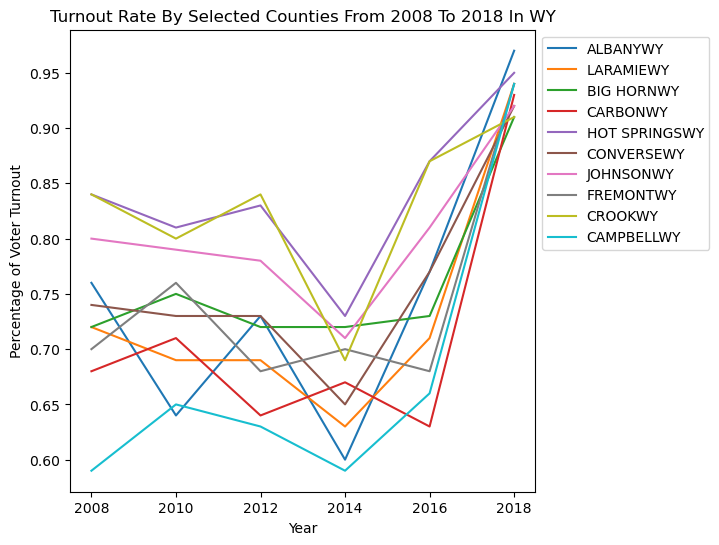

In [41]:
# plot voter turnout by year by county
plt.figure(figsize=(6,6))
for i in range(10):
    plt.plot(year_list, line_list[i], label= county_list[i])
plt.xlabel('Year')
plt.ylabel('Percentage of Voter Turnout')
plt.title('Turnout Rate By Selected Counties From 2008 To 2018 In WY')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The observations from our initial analysis shed light on notable trends in voter turnout across Wyoming's counties:

- Over the past two election cycles, there has been a marked increase in voter turnout across all counties.
- Albany County stands out with the highest turnout rate, representing the sole major metropolitan area in Wyoming.

Building upon these insights, we now aim to delve deeper into the potential impact of location on voter engagement. Our focus shifts towards exploring whether residency in urban, rural, or frontier areas correlates with varying levels of voter turnout. To achieve this, we will embark on an exploratory data analysis of Wyoming's zip codes, categorizing them based on urban, rural, or frontier classifications, and examining the corresponding turnout rates over the recent elections.

In [42]:
df3.select("Residence_Addresses_Zip").count()

290375

In [45]:
# Count null values in the "Residence_Addresses_City" column and sum the counts
na_count_zip = df3.select(pyspark_sum(col("Residence_Addresses_Zip").isNull().cast("int"))).collect()[0][0]

print("Total count of null values in the 'Residence_Addresses_Zip' column:", na_count_zip)

Total count of null values in the 'Residence_Addresses_Zip' column: 17


Since we know that there are 17 missing values for zip code, we will remove the observations.

In [46]:
# Dropping na
loc_filtered = df3.na.drop(subset=["Residence_Addresses_Zip"])
loc_filtered.select("Residence_Addresses_Zip").count()

290358

In [47]:
loc_filtered.select("Residence_Addresses_Zip").distinct().count()

182

In [48]:
# Count null values in the "Residence_Addresses_City" column and sum the counts
na_count_zip2 = loc_filtered.select(pyspark_sum(col("Residence_Addresses_Zip").isNull().cast("int"))).collect()[0][0]

print("Total count of null values in the 'Residence_Addresses_Zip' column:", na_count_zip2)

Total count of null values in the 'Residence_Addresses_Zip' column: 0


In [53]:
# Perform groupBy with aggregation for all columns
grouped_df = loc_filtered.groupBy("Residence_Addresses_Zip").count()

# Sort the DataFrame
sorted_df = grouped_df.orderBy(grouped_df["count"].desc())

joined_df = sorted_df.join(loc_filtered, on="Residence_Addresses_Zip")

sorted_counts_df = joined_df.select('Residence_Addresses_Zip', 'count').distinct().orderBy(desc('count'))

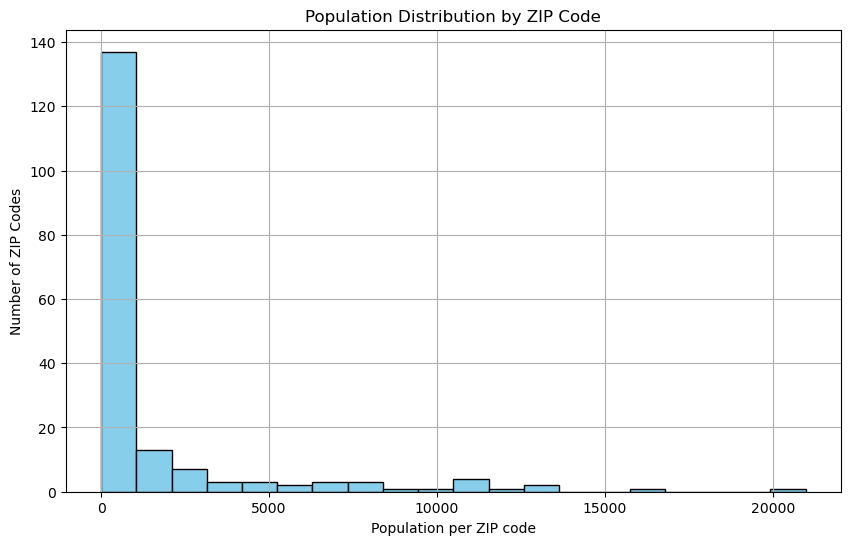

In [58]:
# Extract counts from the DataFrame
counts = sorted_counts_df.select('count').rdd.flatMap(lambda x: x).collect()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Population per ZIP code')
plt.ylabel('Number of ZIP Codes')
plt.title('Population Distribution by ZIP Code')
plt.grid(True)
plt.show()

By examining the count distribution, it's evident that numerous zip codes have fewer than 1000 registered voters, while only one zip code boasts over 20,000 registered voters.

Moving forward, our objective is to categorize zip codes into three distinct areas: urban, suburban, and rural, based on population demographics. Given Wyoming's relatively low population density, we've devised the following classification criteria:
    
    - Urban: More than 10,000 eligible voters
    - Suburban: Between 1,000 and 9,999 eligible voters
    - Rural: Fewer than 1,000 eligible voters

In [63]:
# Define the conditions for labeling
conditions = [
    (col("count") > 10000, "urban"),
    (col("count").between(1000, 9999), "suburban"),
    (col("count").between(0, 999), "rural")
]

# Define the default label
default_label = "unknown"

# Create the label column based on the conditions
loc_filtered_with_label = joined_df.withColumn("label", when(conditions[0][0], conditions[0][1])
                                                        .when(conditions[1][0], conditions[1][1])
                                                        .when(conditions[2][0], conditions[2][1])
                                                        .otherwise(default_label))

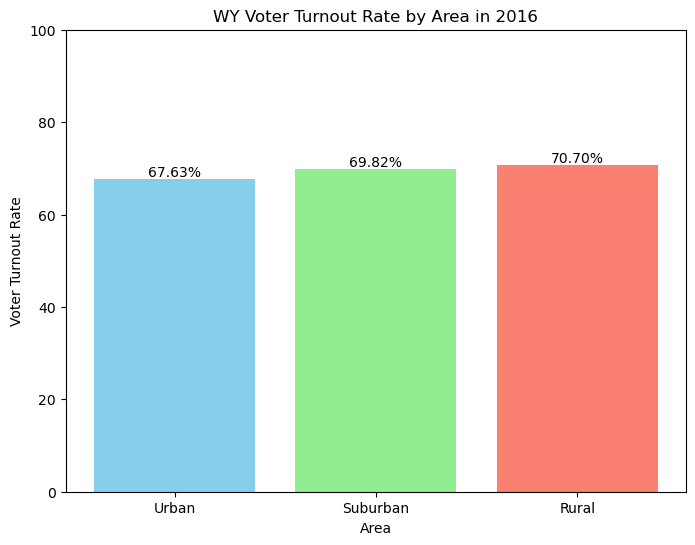

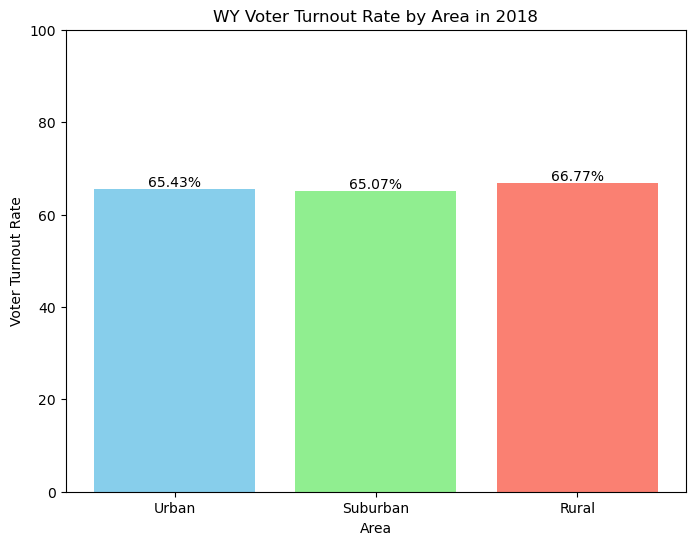

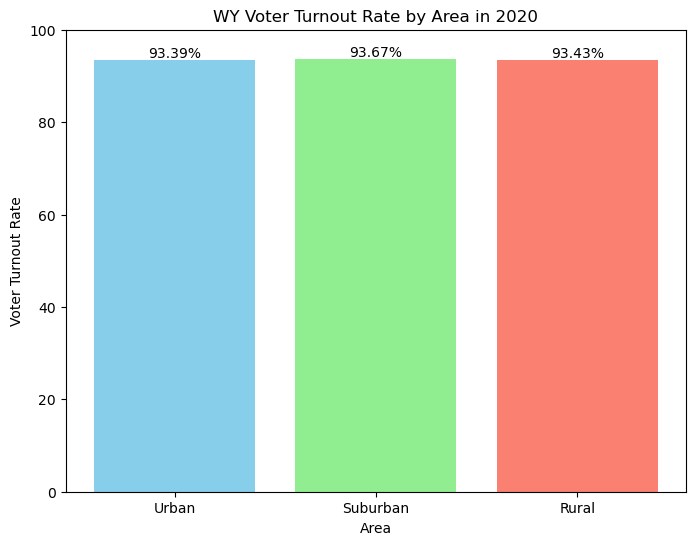

In [64]:
# Function to calculate turnout rate
def calculate_turnout_rate(df, year):
    total_voters = df.count()
    if total_voters == 0:
        return 0
    voted_count = df.filter(f'General_{year} == "Y"').count()
    turnout_rate = (voted_count / total_voters) * 100
    return turnout_rate

# Function to plot bar chart for each year
def plot_bar_chart(df, year):
    urban_turnout = calculate_turnout_rate(df.filter(df['label'] == 'urban'), year)
    rural_turnout = calculate_turnout_rate(df.filter(df['label'] == 'suburban'), year)
    frontier_turnout = calculate_turnout_rate(df.filter(df['label'] == 'rural'), year)

    turnout_data = [urban_turnout, rural_turnout, frontier_turnout]
    areas = ['Urban', 'Suburban', 'Rural']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(areas, turnout_data, color=['skyblue', 'lightgreen', 'salmon'])

    for bar, turnout_rate in zip(bars, turnout_data):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{turnout_rate:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Area')
    plt.ylabel('Voter Turnout Rate')
    plt.title(f'WY Voter Turnout Rate by Area in {year}')
    plt.ylim(0, 100)
    plt.show()

# Plotting for each year
for year in [2016, 2018, 2020]:
    plot_bar_chart(loc_filtered_with_label, year)

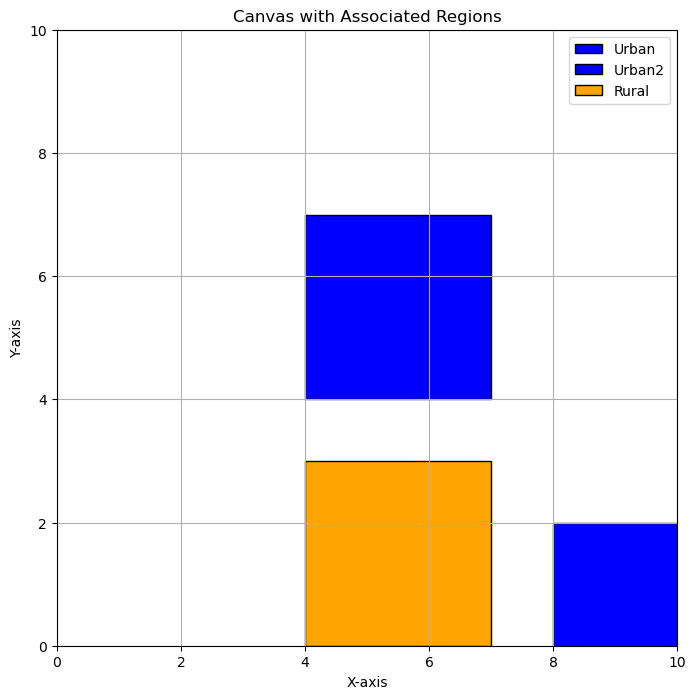

In [165]:
# Define the size of the canvas
canvas_size = 10

# Create a blank canvas
canvas = np.zeros((canvas_size, canvas_size))

# Define the regions and their coordinates
regions = {
    'Urban': [(10, 2), (8, 0)],
    'Urban2': [(7, 7), (4, 4)],
    'Rural': [(4, 0), (7, 3)],
}

# Define colors for each region
colors = {
    'Urban': 'blue',
    'Urban2': 'blue',
    'Suburban': 'lightblue',
    'Rural': 'orange'
}

# Plot the regions
fig, ax = plt.subplots(figsize=(8, 8))
for region, coords in regions.items():
    rect = patches.Rectangle(coords[0], coords[1][0]-coords[0][0], coords[1][1]-coords[0][1],
                             linewidth=1, edgecolor='black', facecolor=colors[region], label=region)
    ax.add_patch(rect)

# Customize plot
plt.xlim(0, canvas_size)
plt.ylim(0, canvas_size)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Canvas with Associated Regions')

# Add legend
plt.legend()

plt.grid(True)
plt.show()


Upon analysis of the plots, it becomes evident that the turnout rates across different zip codes or locations exhibit remarkable consistency. Regardless of whether the area is classified as urban, rural, or frontier, the voter engagement levels appear relatively uniform. This finding suggests that factors beyond geographical location may play a more significant role in determining voter turnout. 

However, amidst this consistency, a notable trend emerges concerning the overall turnout rates over the years. In both the 2016 and 2018 elections, the turnout rates hover around the 65-70% range, indicative of a consistent level of civic participation. Intriguingly, the 2020 election stands out with a remarkable surge in turnout, reaching approximately 93%. This considerable increase in voter engagement signals a notable shift in public participation and perhaps reflects heightened political awareness or motivation during that electoral cycle.

## Ethnicity

Next we want to find the impact of ethnicity on turnout, so we will plot turnout rates aggregated by different racial category (white, black, hispanic, asian)

In [73]:
eth_df = df3.select('Voters_Age', 'Ethnic_Description', 'EthnicGroups_EthnicGroup1Desc', 'General_2020', 'General_2018'
                   ).na.drop(subset = ['Voters_Age']).na.drop(subset = ['Ethnic_Description'])
eth_df.show(10)

+----------+------------------+-----------------------------+------------+------------+
|Voters_Age|Ethnic_Description|EthnicGroups_EthnicGroup1Desc|General_2020|General_2018|
+----------+------------------+-----------------------------+------------+------------+
|        22|             Irish|                     European|        null|           Y|
|        29|     English/Welsh|                     European|        null|        null|
|        30|     English/Welsh|                     European|           Y|           Y|
|        87|     English/Welsh|                     European|           Y|           Y|
|        70|            German|                     European|           Y|           Y|
|        71|            German|                     European|           Y|           Y|
|        23|             Irish|                     European|           Y|           Y|
|        31|     English/Welsh|                     European|           Y|           Y|
|        26|             Scots| 

In [74]:
eth_ct_df = eth_df.groupBy('EthnicGroups_EthnicGroup1Desc').count().withColumnRenamed('count', 'total')
eth_ct_df.show()

+-----------------------------+------+
|EthnicGroups_EthnicGroup1Desc| total|
+-----------------------------+------+
|         East and South Asian|  1168|
|                     European|159163|
|                        Other|  1769|
|         Likely African-Am...|   184|
|         Hispanic and Port...|  7260|
+-----------------------------+------+



In [75]:
eth_df.count()

169544

In [76]:
df3.select('EthnicGroups_EthnicGroup1Desc').show(10)

+-----------------------------+
|EthnicGroups_EthnicGroup1Desc|
+-----------------------------+
|                     European|
|                     European|
|                     European|
|                     European|
|                     European|
|                         null|
|                         null|
|                         null|
|                     European|
|                     European|
+-----------------------------+
only showing top 10 rows



In [77]:
eth_cts_2020_df = eth_df.groupBy('EthnicGroups_EthnicGroup1Desc', 'General_2020').count()
eth_cts_2020_df.show()

+-----------------------------+------------+------+
|EthnicGroups_EthnicGroup1Desc|General_2020| count|
+-----------------------------+------------+------+
|                        Other|           Y|  1659|
|         East and South Asian|        null|    65|
|                     European|        null|  8130|
|                     European|           Y|151033|
|         Likely African-Am...|           Y|   174|
|         Hispanic and Port...|           Y|  6721|
|         East and South Asian|           Y|  1103|
|                        Other|        null|   110|
|         Likely African-Am...|        null|    10|
|         Hispanic and Port...|        null|   539|
+-----------------------------+------------+------+



In [78]:
eth_df.select('Voters_Age').distinct().orderBy('Voters_Age').show(10)

+----------+
|Voters_Age|
+----------+
|        20|
|        21|
|        22|
|        23|
|        24|
|        25|
|        26|
|        27|
|        28|
|        29|
+----------+
only showing top 10 rows



In [79]:
eth_cts_2020_df2 = eth_cts_2020_df.filter(eth_cts_2020_df['General_2020'] != "null").withColumnRenamed('count', 'voted')
eth_cts_2020_df2.show()

+-----------------------------+------------+------+
|EthnicGroups_EthnicGroup1Desc|General_2020| voted|
+-----------------------------+------------+------+
|                        Other|           Y|  1659|
|                     European|           Y|151033|
|         Likely African-Am...|           Y|   174|
|         Hispanic and Port...|           Y|  6721|
|         East and South Asian|           Y|  1103|
+-----------------------------+------------+------+



In [80]:
eth_cts_2020_df3 = eth_cts_2020_df2.join(eth_ct_df, "EthnicGroups_EthnicGroup1Desc", "inner")
eth_cts_2020_df3.show()

+-----------------------------+------------+------+------+
|EthnicGroups_EthnicGroup1Desc|General_2020| voted| total|
+-----------------------------+------------+------+------+
|         East and South Asian|           Y|  1103|  1168|
|                     European|           Y|151033|159163|
|                        Other|           Y|  1659|  1769|
|         Likely African-Am...|           Y|   174|   184|
|         Hispanic and Port...|           Y|  6721|  7260|
+-----------------------------+------------+------+------+



In [81]:
eth_cts_2020_df4 = eth_cts_2020_df3.withColumn(
    'total_turnout', round(eth_cts_2020_df3['voted'] / 169544, 2)).withColumn(
    'sub_turnout', round(eth_cts_2020_df3['voted'] / eth_cts_2020_df3['total'], 2))
eth_cts_2020_df4.show()

+-----------------------------+------------+------+------+-------------+-----------+
|EthnicGroups_EthnicGroup1Desc|General_2020| voted| total|total_turnout|sub_turnout|
+-----------------------------+------------+------+------+-------------+-----------+
|                        Other|           Y|  1659|  1769|         0.01|       0.94|
|                     European|           Y|151033|159163|         0.89|       0.95|
|         Likely African-Am...|           Y|   174|   184|          0.0|       0.95|
|         Hispanic and Port...|           Y|  6721|  7260|         0.04|       0.93|
|         East and South Asian|           Y|  1103|  1168|         0.01|       0.94|
+-----------------------------+------------+------+------+-------------+-----------+



We see that our plot is skewed because the demographics of Wyoming are overwhelmingly of the White ethnicity, making it difficult to make clear judgements based off of this.

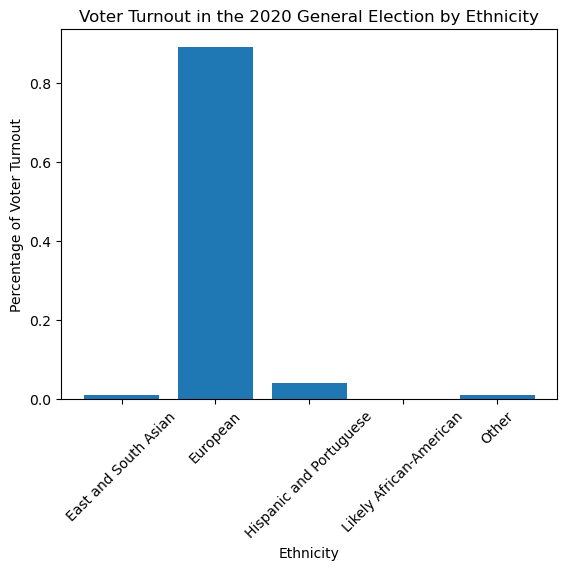

In [82]:
eth_cts_2020_plot_df = eth_cts_2020_df4.orderBy('EthnicGroups_EthnicGroup1Desc').toPandas()
plt.bar(eth_cts_2020_plot_df['EthnicGroups_EthnicGroup1Desc'], eth_cts_2020_plot_df['total_turnout'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Voter Turnout')
plt.title('Voter Turnout in the 2020 General Election by Ethnicity')
plt.xticks(rotation=45)
plt.show()

We plot by relative proportion of turnout instead, to find which ethnicities comparatively participate more in the demographic process. We see high and roughly even participation rates across all ethnicities, which is encouraging, but also indicates that ethnicity is not a salient factor in determining participation.

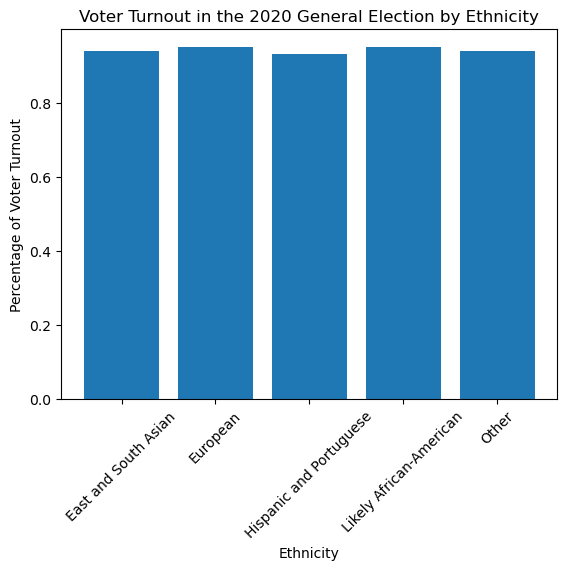

In [83]:
plt.bar(eth_cts_2020_plot_df['EthnicGroups_EthnicGroup1Desc'], eth_cts_2020_plot_df['sub_turnout'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Voter Turnout')
plt.title('Voter Turnout in the 2020 General Election by Ethnicity')
plt.xticks(rotation = 45)
plt.show()

In [96]:
eth_cts_2018_df = eth_df.groupBy('EthnicGroups_EthnicGroup1Desc', 'General_2018').count()
eth_cts_2018_df.show()

+-----------------------------+------------+------+
|EthnicGroups_EthnicGroup1Desc|General_2018| count|
+-----------------------------+------------+------+
|                        Other|           Y|  1465|
|         East and South Asian|        null|   259|
|                     European|        null| 31522|
|                     European|           Y|127641|
|         Likely African-Am...|           Y|   155|
|         Hispanic and Port...|           Y|  5495|
|         East and South Asian|           Y|   909|
|                        Other|        null|   304|
|         Likely African-Am...|        null|    29|
|         Hispanic and Port...|        null|  1765|
+-----------------------------+------------+------+



In [97]:
eth_cts_2018_df2 = eth_cts_2018_df.filter(eth_cts_2018_df['General_2018'] != "null").withColumnRenamed('count', 'voted')

In [98]:
eth_cts_2018_df3 = eth_cts_2018_df2.join(eth_ct_df, "EthnicGroups_EthnicGroup1Desc", "inner")

In [99]:
eth_cts_2018_df4 = eth_cts_2018_df3.withColumn(
    'total_turnout', round(eth_cts_2018_df3['voted'] / 169544, 2)).withColumn(
    'sub_turnout', round(eth_cts_2018_df3['voted'] / eth_cts_2018_df3['total'], 2))

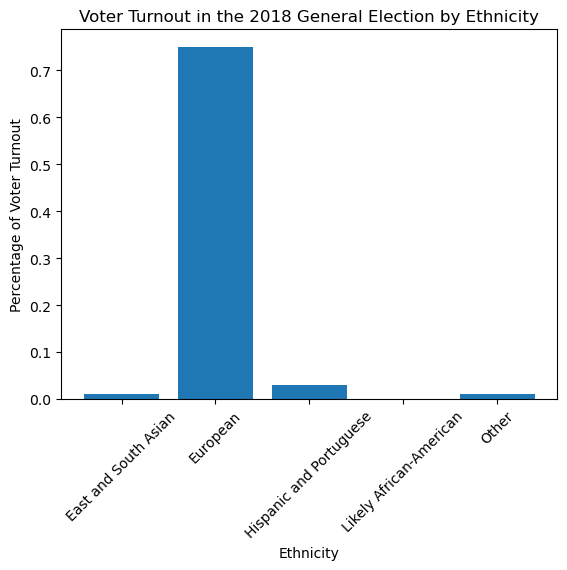

In [100]:
eth_cts_2018_plot_df = eth_cts_2018_df4.orderBy('EthnicGroups_EthnicGroup1Desc').toPandas()
plt.bar(eth_cts_2018_plot_df['EthnicGroups_EthnicGroup1Desc'], eth_cts_2018_plot_df['total_turnout'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Voter Turnout')
plt.title('Voter Turnout in the 2018 General Election by Ethnicity')
plt.xticks(rotation=45)
plt.show()

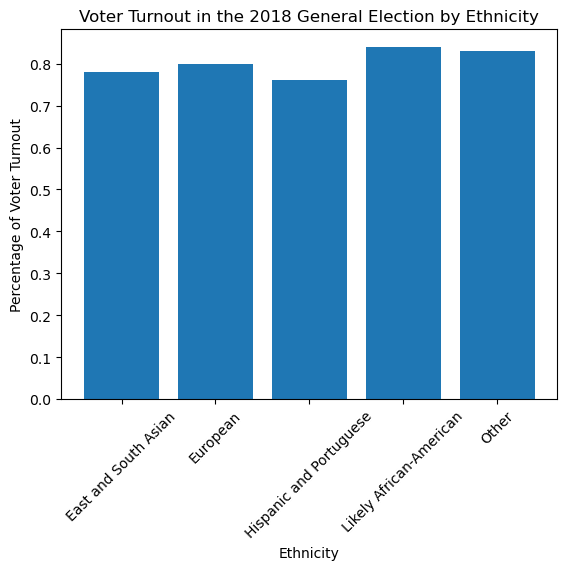

In [101]:
plt.bar(eth_cts_2018_plot_df['EthnicGroups_EthnicGroup1Desc'], eth_cts_2018_plot_df['sub_turnout'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Voter Turnout')
plt.title('Voter Turnout in the 2018 General Election by Ethnicity')
plt.xticks(rotation = 45)
plt.show()

In [102]:
eur_df = eth_df.filter(eth_df['EthnicGroups_EthnicGroup1Desc'] == 'European')
eur_df_count = eur_df.groupBy('Ethnic_Description', 'General_2020').count().withColumnRenamed('count', 'total')
eur_df_voters = eur_df.filter(eur_df['General_2020'] != "null").groupBy('Ethnic_Description', 'General_2020').count().withColumnRenamed('count', 'voted')

In [103]:
eur_df_count_2020 = eur_df_count.join(eur_df_voters, "Ethnic_Description", "inner")

In [104]:
eur_df4 = eur_df_count_2020.withColumn(
    'total_turnout', round(eur_df_count_2020['voted'] / 169544, 2)).withColumn(
    'sub_turnout', round(eur_df_count_2020['voted'] / eur_df_count_2020['total'], 2))

Since "White" overwhelmingly dominates the ethnicity category, we try to plot subcategories of the White ethnicity to see if there are any interesting patterns or trends, but once again, we see that there is no eveident correlation.

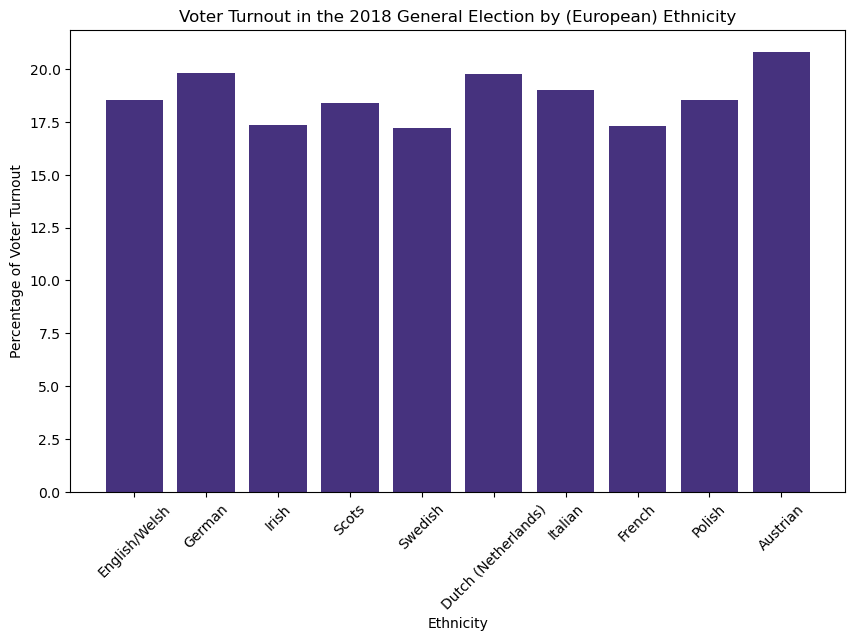

In [136]:
plt.figure(figsize=(10, 6))
# Set the Seaborn color palette
p = sns.color_palette("viridis")
sns.set_palette(p)

eur_plot_df = eur_df4.orderBy('total_turnout', ascending=False).toPandas()[0:20]
plt.bar(eur_plot_df['Ethnic_Description'], eur_plot_df['sub_turnout'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Voter Turnout')
plt.title('Voter Turnout in the 2018 General Election by (European) Ethnicity')
plt.xticks(rotation=45)
plt.show()

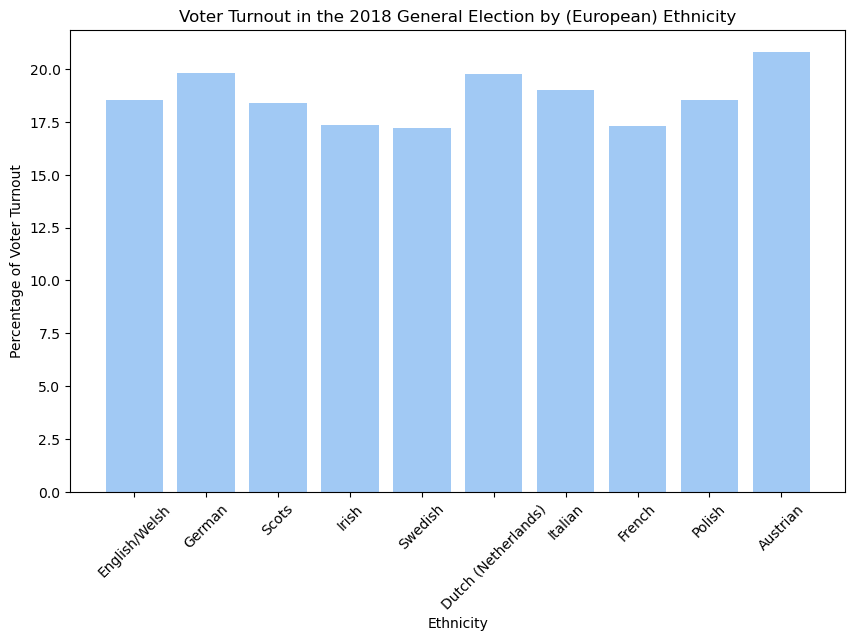

In [131]:
# Set the Seaborn color palette
p = sns.color_palette("pastel", 5)
sns.set_palette(p)

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(eur_plot_df['Ethnic_Description'], eur_plot_df['sub_turnout'])
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Voter Turnout')
plt.title('Voter Turnout in the 2018 General Election by (European) Ethnicity')
plt.xticks(rotation=45)
plt.show()


## Income/Wealth

Our research question asked about the connection between income and turnout. We can expand on this further, since markers of wealth (house price, etc.) are directly based off of income, to construct a logistic regression model to find the relationship between increased wealth and voter turnout, based on several wealth-related variables in our dataset.

Choose General Election 2018 as our measure of turnout (response variable)

In [106]:
research_cols = ["CommercialData_EstimatedHHIncomeAmount","CommercialData_StateIncomeDecile", "CommercialDataLL_Home_Owner_Or_Renter", 
                "CommercialData_EstHomeValue", "CommercialData_PropertyType", "county_fips", "General_2018"]

wealth_df = df3.select(*research_cols)

In [107]:
df3.select('CommercialData_StateIncomeDecile').show(5)


+--------------------------------+
|CommercialData_StateIncomeDecile|
+--------------------------------+
|                               8|
|                               0|
|                            null|
|                               0|
|                               0|
+--------------------------------+
only showing top 5 rows



Once again, we fill in the false nulls in our new dataframe of wealth-related variables.

In [108]:
wealth_df = wealth_df.na.fill(value="no")

Perform data cleaning on numeric variables separately from categorical variables, here we convert the strings of income to numeric and fill-in missing values with the average income for that county. 

In [109]:
# Use a combination of StringIndexer, CategoryIndexing, and OneHotEncoder and to convert the categorical variables to numerics.

# First, Remove the "$" sign from CommercialData_EstimatedHHIncomeAmount and CommercialData_EstHomeValue and convert data type to numerics
wealth_df2 = wealth_df.withColumn("CommercialData_EstimatedHHIncomeAmount", regexp_replace(col("CommercialData_EstimatedHHIncomeAmount"), "\$", "").cast(IntegerType())) \
       .withColumn("CommercialData_EstHomeValue", regexp_replace(col("CommercialData_EstHomeValue"), "\$", "").cast(IntegerType()))

# Compute average value per county for these columns and round it
avg_values = wealth_df2.groupBy("county_fips").agg(
    round(avg("CommercialData_EstimatedHHIncomeAmount"), 0).alias("avg_EstimatedHHIncomeAmount").cast(IntegerType()),
    round(avg("CommercialData_EstHomeValue"), 0).alias("avg_EstHomeValue").cast(IntegerType()),
    round(avg("CommercialData_StateIncomeDecile"), 0).alias("avg_IncomeDecible").cast(IntegerType())
)

# Join average values back and fill missing data for both columns
wealth_df3 = wealth_df2.join(avg_values, "county_fips", "left") \
       .withColumn("Estimate_HHI_filled", coalesce("CommercialData_EstimatedHHIncomeAmount", "CAST(round(avg(CommercialData_EstimatedHHIncomeAmount), 0) AS avg_EstimatedHHIncomeAmount AS INT)").cast(IntegerType())) \
       .withColumn("Estimate_HomeValued_filled", coalesce("CommercialData_EstHomeValue", "CAST(round(avg(CommercialData_EstimatedHHIncomeAmount), 0) AS avg_EstimatedHHIncomeAmount AS INT)").cast(IntegerType())) \
       .withColumn("Estimate_IncomeBracket_filled", coalesce("CommercialData_StateIncomeDecile", "CAST(round(avg(CommercialData_StateIncomeDecile), 0) AS avg_IncomeDecible AS INT)").cast(IntegerType()))

# remove original value columns if they are no longer needed
wealth_df4 = wealth_df3.drop("CommercialData_EstimatedHHIncomeAmount", "CommercialData_EstHomeValue", "avg_EstimatedHHIncomeAmount", "avg_EstHomeValue") \
       .withColumnRenamed("Estimate_HHI_filled", "EstimatedHHIncomeAmount") \
       .withColumnRenamed("Estimate_HomeValued_filled", "EstHomeValue") \
       .withColumnRenamed("Estimate_IncomeBracket_filled", "EstIncomeBracket")

In [113]:
# test if fill-in worked
# Check whether there is missing data for these two columns
print('Missing data:', wealth_df4.where(wealth_df4['CAST(round(avg(CommercialData_StateIncomeDecile), 0) AS avg_IncomeDecible AS INT)'].isNull()).count())

Missing data: 0


In [114]:
wealth_df4 = wealth_df4.drop('county_fips')

In [291]:
wealth_df4.write\
    .format("csv")\
    .option("header","true")\
    .save("gs://final-project-bucket-135/wealth_df4_5")

In [ ]:
wealth_df4 = spark.read.option("header", "true").csv("gs://final-project-bucket-135/wealth_df4_5")

We apply one-hot encoding on the categorical variables so they can be processed by our model.

In [115]:
categorical_cols = ["CommercialDataLL_Home_Owner_Or_Renter", "CommercialData_PropertyType"]

stages = [] # stages in Pipeline

for categoricalCol in categorical_cols:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol,outputCol=categoricalCol + "Index", handleInvalid="skip")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols=[categoricalCol + "classVec"])
    # Add stages. These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [116]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="General_2018", outputCol="label", handleInvalid="skip")
stages += [label_stringIdx]

In [117]:
# Transform all features into a vector using VectorAssembler
numericCols = ["EstimatedHHIncomeAmount", "EstHomeValue", "EstIncomeBracket"]
assemblerInputs = [c + "classVec" for c in categorical_cols] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid='skip')
stages += [assembler]

In [118]:
data_types = wealth_df4.select('EstimatedHHIncomeAmount').dtypes
print(data_types)

[('EstimatedHHIncomeAmount', 'int')]


In [119]:
wealth_df4 = wealth_df4.withColumn('EstimatedHHIncomeAmount', col('EstimatedHHIncomeAmount').cast("integer"))
wealth_df4 = wealth_df4.withColumn('EstHomeValue', col('EstHomeValue').cast("integer"))
wealth_df4 = wealth_df4.withColumn('EstIncomeBracket', col('EstIncomeBracket').cast("integer"))

In [120]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(wealth_df4)
preppedDataDF = pipelineModel.transform(wealth_df4)

In [121]:
# Keep relevant columns
cols = wealth_df4.columns
selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)

In [322]:
dataset.write.parquet("gs://final-project-bucket-135/dataset_after_preprocessing6.parquet")

In [104]:
# Load the dataset for building models
dataset = spark.read.parquet("gs://final-project-bucket-135/dataset_after_preprocessing6.parquet")

In [122]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed=42)
print(trainingData.count())
print(testData.count())

197748


49416


In [123]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [124]:
# Transform the data to include the 'label' column
df_with_labels = lrModel.transform(dataset)

# Count the number of instances of each class
label_counts = df_with_labels.groupBy("label").count()

# Show the results
label_counts.show()

+-----+------+
|label| count|
+-----+------+
|  0.0|162107|
|  1.0| 85150|
+-----+------+



In [125]:
predictions = lrModel.transform(testData)

In [126]:
selected = predictions.select("label", "prediction", "probability", "EstHomeValue", "EstimatedHHIncomeAmount")
selected.show(10)

+-----+----------+--------------------+------------+-----------------------+
|label|prediction|         probability|EstHomeValue|EstimatedHHIncomeAmount|
+-----+----------+--------------------+------------+-----------------------+
|  0.0|       0.0|[0.76254439394549...|      162500|                  10000|
|  0.0|       0.0|[0.76055641653321...|      127285|                  11000|
|  0.0|       0.0|[0.76114620566636...|      139287|                  11000|
|  0.0|       0.0|[0.76432909142996...|      209733|                  12000|
|  0.0|       0.0|[0.75682705028545...|       62500|                  13000|
|  0.0|       0.0|[0.75874639961036...|      101220|                  13000|
|  0.0|       0.0|[0.76137290549257...|      154548|                  13000|
|  0.0|       0.0|[0.76266464670655...|      180923|                  13000|
|  0.0|       0.0|[0.76539721397534...|      237045|                  13000|
|  0.0|       0.0|[0.76541496262241...|      237411|                  13000|

In [127]:
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.6425090199584866

We use binary classification to evaluate the performance of logistic regression model. Our result is approximately 64%. A random guess model would be expected to score around 0.5, which indicates that our model is better than a random prediction, which in turn suggests that income is a significant predictor of turnout, in contrast to the previous two factors we explored, ethnicity and location.

Predictions are highly correlated so we will try using elastic net regularization penalty. We use cross-validation to find best values elastic net parameter.

In [112]:
# Create an instance of BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

# Define a grid of parameters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) \
    .build()

# Create CrossValidator with LogisticRegression model, evaluator, and paramGrid
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Number of folds for cross-validation

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(trainingData)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Get the best value of elasticNetParam
bestElasticNetParam = bestModel._java_obj.getElasticNetParam()
print("Best elasticNetParam:", bestElasticNetParam)

Best elasticNetParam: 0.6


In [113]:
# Create new LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, 
                        elasticNetParam = bestElasticNetParam)
# Train model with Training Data
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.6421802565549408

Notice that our dataset is imbalanced with a 2:1 of classes 0.0 vs 1.0. This may bias the model in one direction. As one strategy to improve accuracy, we will duplicate the rows belonging to the minority class in order to have roughly even distribution of the classes in the training set.

In [114]:
label_counts = dataset.groupBy('label').count()

# Separate the majority and minority classes
majority_class = label_counts.filter(col('label') == 0.0)
minority_class = label_counts.filter(col('label') == 1.0)

# Count the number of samples in each class
majority_count = majority_class.collect()[0]['count']
minority_count = minority_class.collect()[0]['count']
print('majority count', majority_count)
print('minority count', minority_count)
oversampling_ratio = math.ceil(majority_count / minority_count)
print('oversampling ratio', oversampling_ratio)

majority count 162107
minority count 85150
oversampling ratio 2


In [115]:
# Filter rows where label is equal to 1.0
filtered_df = dataset.filter(col('label') == 1.0)

# Combine the original DataFrame with the duplicated DataFrame
final_df = dataset.union(filtered_df)

In [116]:
# Assuming 'label' is the name of your label column in df_with_labels
label_counts = final_df.groupBy('label').count()

# Separate the majority and minority classes
majority_class = label_counts.filter(col('label') == 0.0)
minority_class = label_counts.filter(col('label') == 1.0)

# Count the number of samples in each class
majority_count = majority_class.collect()[0]['count']
minority_count = minority_class.collect()[0]['count']
print('majority count', majority_count)
print('minority count', minority_count)
oversampling_ratio = math.ceil(majority_count / minority_count)
print('oversampling ratio', oversampling_ratio)

majority count 162107
minority count 170300
oversampling ratio 1


In [117]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = final_df.randomSplit([0.8, 0.2], seed=42)
print(trainingData.count())
print(testData.count())

266024


66383


In [118]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [119]:
predictions = lrModel.transform(testData)

Our model improved, but barely.

In [120]:
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.642185351608481

Now that we have done individual analyses of each of our topics of interest, it is time to answer the final part of our research question - which of these is the most salient feature in determining turnout rates. We will do regression over all variables of interest - Ethnicity, Income, Age, County.

In [121]:
df3 = spark.read.option("header", "true").csv("gs://final-project-bucket-135/df3_2")

In [122]:
research_cols = ["EthnicGroups_EthnicGroup1Desc","Voters_Age", "county_fips", "CommercialData_EstimatedHHIncome", "General_2018"]

model1_df = df3.select(*research_cols)

In [123]:
model1_df.select("CommercialData_EstimatedHHIncome").show()

+--------------------------------+
|CommercialData_EstimatedHHIncome|
+--------------------------------+
|                    $35000-49999|
|                    $35000-49999|
|                            null|
|                     $1000-14999|
|                    $15000-24999|
|                            null|
|                    $50000-74999|
|                    $50000-74999|
|                  $125000-149999|
|                  $125000-149999|
|                    $75000-99999|
|                    $75000-99999|
|                    $75000-99999|
|                     $1000-14999|
|                    $15000-24999|
|                    $50000-74999|
|                    $50000-74999|
|                    $75000-99999|
|                    $75000-99999|
|                    $50000-74999|
+--------------------------------+
only showing top 20 rows



Fill in missing data using the average once again.

In [124]:
# Define a function to calculate the midpoint of a range
def calculate_midpoint(entry):
    # Check if the entry contains a hyphen
    if entry is not None:
        entry = entry[1:] # eliminate dollar sign
        if "-" in entry:
            # Split the entry by hyphen, remove any whitespace, and convert to integers
            parts = [int(part.strip()) for part in entry.split("-")]
            # Calculate the midpoint
            midpoint = sum(parts) / 2
            return midpoint
        else:
            # If the entry doesn't contain a hyphen, return the entry as is
            return float(entry[:-1])
    else:
        return None

# Register the UDF
calculate_midpoint_udf = udf(calculate_midpoint, DoubleType())

# Apply the UDF to the column
model1_v_df = model1_df.withColumn("CommercialData_EstimatedHHIncome", 
                                    calculate_midpoint_udf(col("CommercialData_EstimatedHHIncome")))

model1_v_df.show()

+-----------------------------+----------+-----------+--------------------------------+------------+
|EthnicGroups_EthnicGroup1Desc|Voters_Age|county_fips|CommercialData_EstimatedHHIncome|General_2018|
+-----------------------------+----------+-----------+--------------------------------+------------+
|                     European|        22|      56001|                         42499.5|           Y|
|                     European|      null|      56001|                         42499.5|           Y|
|                     European|      null|      56001|                            null|        null|
|                     European|      null|      56001|                          7999.5|           Y|
|                     European|        29|      56001|                         19999.5|        null|
|                         null|      null|      56001|                            null|           Y|
|                         null|        39|      56001|                         62499.5|    

In [125]:
# Compute average value per county for this column and round it
income_avg_values = model1_v_df.groupBy("county_fips").agg(
    round(avg("CommercialData_EstimatedHHIncome"), 0).alias("EstimatedHHIncome")
)

# Join average values back and fill missing data for both columns
model1_v1_df = model1_v_df.join(income_avg_values, "county_fips", "left") \
       .withColumn("EstimatedHHIncome", coalesce("CommercialData_EstimatedHHIncome", "EstimatedHHIncome"))

# remove original value columns if they are no longer needed
model1_v2_df = model1_v1_df.drop("CommercialData_EstimatedHHIncome")

In [126]:
model1_v2_df.show(10)

+-----------+-----------------------------+----------+------------+-----------------+
|county_fips|EthnicGroups_EthnicGroup1Desc|Voters_Age|General_2018|EstimatedHHIncome|
+-----------+-----------------------------+----------+------------+-----------------+
|      56001|                     European|        22|           Y|          42499.5|
|      56001|                     European|      null|           Y|          42499.5|
|      56001|                     European|      null|        null|          86655.0|
|      56001|                     European|      null|           Y|           7999.5|
|      56001|                     European|        29|        null|          19999.5|
|      56001|                         null|      null|           Y|          86655.0|
|      56001|                         null|        39|           Y|          62499.5|
|      56001|                         null|        39|           Y|          62499.5|
|      56001|                     European|        30|

In [127]:
print(model1_v1_df.where(model1_v1_df['EstimatedHHIncome'].isNull()).count())

0


In [128]:
model1_v3_df = model1_v2_df.na.drop(subset = ['Voters_Age'])

In [129]:
model1_v3_df.select('Voters_Age').limit(10).show()

+----------+
|Voters_Age|
+----------+
|        22|
|        29|
|        39|
|        39|
|        30|
|        87|
|        70|
|        71|
|        23|
|        78|
+----------+



In [130]:
categorical_cols = ["EthnicGroups_EthnicGroup1Desc", "county_fips"]

stages = [] # stages in Pipeline

for categoricalCol in categorical_cols:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol,outputCol=categoricalCol + "Index", handleInvalid="skip")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols=[categoricalCol + "classVec"])
    # Add stages. These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [131]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="General_2018", outputCol="label", handleInvalid="skip")
stages += [label_stringIdx]

In [132]:
# Transform all features into a vector using VectorAssembler
numericCols = ["Voters_Age", "EstimatedHHIncome"]
assemblerInputs = [c + "classVec" for c in categorical_cols] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid='skip')
stages += [assembler]

In [133]:
model1_v5_df = model1_v3_df.withColumn('EstimatedHHIncome', col('EstimatedHHIncome').cast("integer"))
model1_v5_df = model1_v5_df.withColumn('Voters_Age', col('Voters_Age').cast("integer"))
model1_v5_df = model1_v5_df.withColumn('county_fips', col('county_fips').cast("string"))

In [134]:
model1_v5_df = model1_v5_df.na.fill(value="no")

In [135]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(model1_v5_df)
preppedDataDF = pipelineModel.transform(model1_v5_df)

In [136]:
# Keep relevant columns
cols = model1_v5_df.columns
selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)

In [ ]:
dataset.write.parquet("gs://final-project-bucket-135/model1_v5_df2.parquet")

In [137]:
model1_v5_df = spark.read.parquet("gs://final-project-bucket-135/model1_v5_df2.parquet")

In [138]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed=42)
print(trainingData.count())
print(testData.count())

149563


37325


In [139]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [140]:
predictions = lrModel.transform(testData)

In [141]:
selected = predictions.select("label", "prediction", "probability", 
                              "county_fips", "EthnicGroups_EthnicGroup1Desc",
                              "Voters_Age", "EstimatedHHIncome")
selected.show(10)

+-----+----------+--------------------+-----------+-----------------------------+----------+-----------------+
|label|prediction|         probability|county_fips|EthnicGroups_EthnicGroup1Desc|Voters_Age|EstimatedHHIncome|
+-----+----------+--------------------+-----------+-----------------------------+----------+-----------------+
|  0.0|       1.0|[0.44550923196802...|      56005|                     European|        21|            62499|
|  0.0|       1.0|[0.44550923196802...|      56005|                     European|        21|            62499|
|  0.0|       1.0|[0.45721566246918...|      56005|                     European|        21|            87499|
|  0.0|       1.0|[0.46896953594415...|      56005|                     European|        21|           112499|
|  0.0|       1.0|[0.48075793891057...|      56005|                     European|        21|           137499|
|  0.0|       1.0|[0.48075793891057...|      56005|                     European|        21|           137499|
|

In [142]:
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.6694995156254059

This model appears to work better than our previous model which only took into account wealth-related variables. Let's find the coefficient values on each predictor to find out which is the most important one.

In [141]:
# Get input feature column names
input_feature_cols = assembler.getInputCols()

# Associate each weight to a feature
feature_coefficients = zip(input_feature_cols, lrModel.coefficients.toArray())

for feature, coefficient in feature_coefficients:
    print("Feature:", feature, "Coefficient:", coefficient)

Feature: CommercialDataLL_Home_Owner_Or_RenterclassVec Coefficient: -0.2096112996359351
Feature: CommercialData_PropertyTypeclassVec Coefficient: 0.6373884808261171
Feature: EstimatedHHIncomeAmount Coefficient: -0.2921945648191167
Feature: EstHomeValue Coefficient: 0.017654881584567197
Feature: EstIncomeBracket Coefficient: 0.6539068186948932


It appears voters age is by far the most important feature in our model, that is, voters age has the biggest influence on turnout. Does being older or younger make one more likely to vote?

We can plot individual voters as a function of age vs turnout

In [142]:
col_list = ['General_2020', 'General_2018', 'General_2016']

In [143]:
turnout_df = df3.select('Voters_Age', 'General_2020', 'General_2018', 'General_2016')

In [144]:
turnout_df.show(10)

+----------+------------+------------+------------+
|Voters_Age|General_2020|General_2018|General_2016|
+----------+------------+------------+------------+
|        22|        null|           Y|        null|
|      null|        null|           Y|        null|
|      null|           Y|        null|        null|
|      null|           Y|           Y|           Y|
|        29|        null|        null|           Y|
|      null|        null|           Y|           Y|
|        39|           Y|           Y|           Y|
|        39|           Y|           Y|           Y|
|        30|           Y|           Y|           Y|
|        87|           Y|           Y|        null|
+----------+------------+------------+------------+
only showing top 10 rows



In [145]:
turnout_df = turnout_df.na.drop(subset = ['Voters_Age'])

In [146]:
turnout_df = turnout_df.na.fill(value="N")

In [147]:
turnout_df = turnout_df.withColumn("General_2020", when(col("General_2020") == 'Y', 1).otherwise(col("General_2020")))
turnout_df = turnout_df.withColumn("General_2020", when(col("General_2020") == 'N', 0).otherwise(col("General_2020")))

turnout_df = turnout_df.withColumn("General_2018", when(col("General_2018") == 'Y', 1).otherwise(col("General_2018")))
turnout_df = turnout_df.withColumn("General_2018", when(col("General_2018") == 'N', 0).otherwise(col("General_2018")))

turnout_df = turnout_df.withColumn("General_2016", when(col("General_2016") == 'Y', 1).otherwise(col("General_2016")))
turnout_df = turnout_df.withColumn("General_2016", when(col("General_2016") == 'N', 0).otherwise(col("General_2016")))

In [148]:
turnout_df2 = turnout_df.withColumn(
    'SUM1',
    sum([F.col(c) for c in col_list]))

In [149]:
turnout_df3 = turnout_df2.drop(*['General_2020', 'General_2018', 'General_2016'])

In [150]:
turnout_df3.show(10)

+----------+----+
|Voters_Age|SUM1|
+----------+----+
|        22| 1.0|
|        29| 1.0|
|        39| 3.0|
|        39| 3.0|
|        30| 3.0|
|        87| 2.0|
|        70| 3.0|
|        71| 3.0|
|        23| 3.0|
|        78| 2.0|
+----------+----+
only showing top 10 rows



In [151]:
# Define age ranges
age_ranges = [(18, 29), (30, 49), (50, 65), (66, 120)]

# Group by age ranges and calculate average of second column
result = turnout_df3.groupBy(
    *[when((col("Voters_Age") >= lower) & (col("Voters_Age") <= upper), f"{lower}-{upper}").otherwise(None).alias(f"AgeRange-{lower}") 
      for lower, upper in age_ranges]).avg()

In [152]:
result.show(10)

+-----------+-----------+-----------+-----------+------------------+
|AgeRange-18|AgeRange-30|AgeRange-50|AgeRange-66|         avg(SUM1)|
+-----------+-----------+-----------+-----------+------------------+
|       null|      30-49|       null|       null| 2.465411568287164|
|       null|       null|       null|     66-120| 2.755330557219058|
|       null|       null|      50-65|       null|  2.61496034205967|
|      18-29|       null|       null|       null|1.8688918959554954|
+-----------+-----------+-----------+-----------+------------------+



In [153]:
combined_df = result.withColumn("AgeRange", 
                             coalesce(col("AgeRange-18"), col("AgeRange-30"), col("AgeRange-50"), col("AgeRange-66")))

In [154]:
combined_df = combined_df.drop(*['AgeRange-18', 'AgeRange-30', 'AgeRange-50', 'AgeRange-66'])

In [155]:
ordered_df = combined_df.orderBy(
    col("AgeRange")
)

In [156]:
ordered_df.show(10)

+------------------+--------+
|         avg(SUM1)|AgeRange|
+------------------+--------+
|1.8688918959554954|   18-29|
| 2.465411568287164|   30-49|
|  2.61496034205967|   50-65|
| 2.755330557219058|  66-120|
+------------------+--------+



In [157]:
pandas_df = ordered_df.toPandas()

In [158]:
df10 = df3.withColumn("AgeRange", F.lit(None))

for lower, upper in age_ranges:
    df10 = df10.withColumn(
        "AgeRange",
        when((col("Voters_Age") >= lower) & (col("Voters_Age") <= upper), f"{lower}-{upper}")
        .otherwise(col("AgeRange"))
    )

df10 = df10.where(col("AgeRange").isNotNull())

The following line plot aggregates turnout over the last 3 election cycles. For example, if a voter voted in all 3 of the last 3 elections they would receive a perfect score of 3.

Text(0, 0.5, 'Aggregated Turnout over Last 3 Cycles')

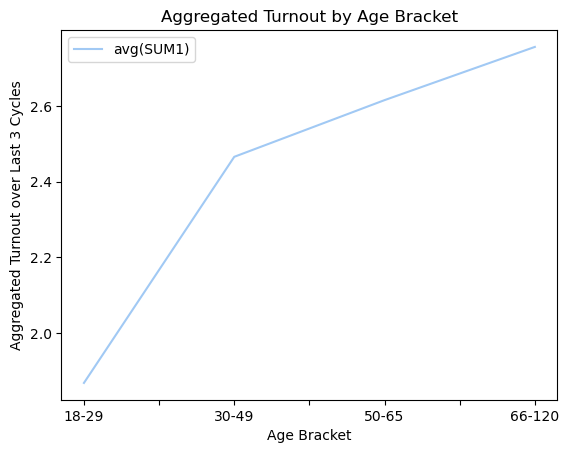

In [164]:
pandas_df.plot(x='AgeRange', y='avg(SUM1)', kind='line')
plt.title('Aggregated Turnout by Age Bracket')
plt.xlabel('Age Bracket')
plt.ylabel('Aggregated Turnout over Last 3 Cycles')

So it appears that voter turnout consistently increases with age, when we plot an aggregate of voter turnout over the last 3 election cycles. Let's plot voter turnout grouped by age bracket separately for each of the last 3 election cycles.

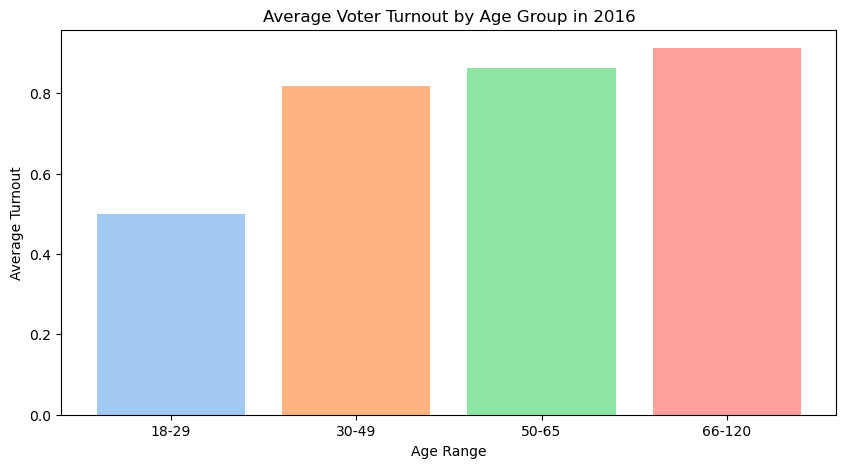

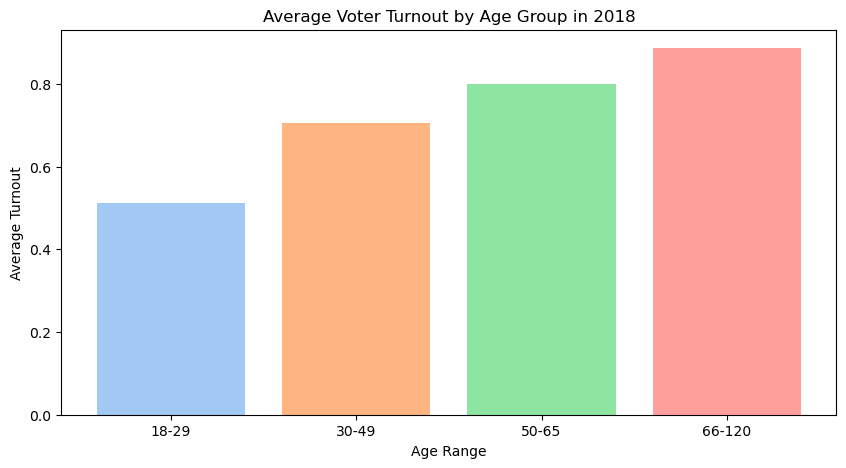

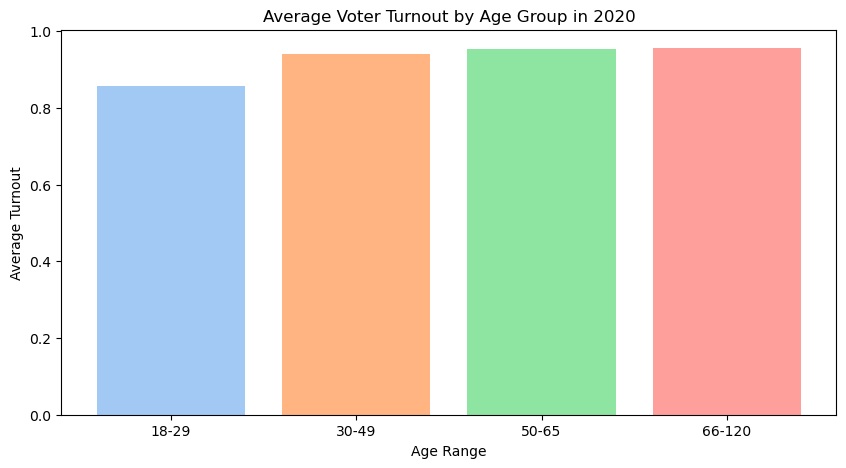

In [166]:
# Set the color palette
sns.set_palette("pastel")

# Define a list of colors
colors = sns.color_palette("pastel", 4)

for year in ['2016', '2018', '2020']:
    df_year = df10.groupBy("AgeRange").agg(
        avg(when(col(f"General_{year}") == 'Y', 1).otherwise(0)).alias(f"avg_turnout_{year}")
    )
    
    pandas_df_year = df_year.toPandas()
    pandas_df_year = pandas_df_year.dropna()
    pandas_df_year.sort_values('AgeRange', inplace=True)
    
    plt.figure(figsize=(10, 5))
    plt.bar(pandas_df_year['AgeRange'], pandas_df_year[f"avg_turnout_{year}"], color=colors)
    plt.title(f'Average Voter Turnout by Age Group in {year}')
    plt.xlabel('Age Range')
    plt.ylabel('Average Turnout')
    plt.show()

## Conclusion

In conclusion, our analysis reveals several key findings regarding voter participation. Firstly, we found that factors such as location and ethnicity have minimal discernible impact on voter turnout rates. However, income and wealth emerge as significant predictors, indicating that individuals with higher economic status are more likely to participate in the electoral process.

Additionally, age demonstrates a notable correlation with voter turnout, with older individuals exhibiting higher rates of participation compared to their younger counterparts. These insights underscore the importance of socioeconomic factors and age demographics in shaping voter behavior, highlighting avenues for targeted outreach and engagement efforts in future electoral campaigns.

## Recommendations for Political Campaign

The main focus to increase turnout rate in Wyoming is to encourage younger voters to vote more and target younger voters in advertising.

Potential measures:

- Youth Engagement Initiatives: 
Implement youth engagement initiatives such as educational workshops, social media campaigns, and community events aimed at mobilizing younger voters. Highlight the significance of their voices in shaping the future and address any barriers to participation they may face. Establish youth leadership programs that provide opportunities for young individuals to take on active roles in local politics and community decision-making. Encourage youth representation on advisory boards, task forces, and committees.

- Integration into High School Curriculum: 
Advocate for the integration of civics and political education into high school curricula. Incorporate modules on government structures, electoral processes, and critical thinking skills to empower students to become informed and active citizens.

- Focused Messaging:
Craft messaging that resonates with diverse demographics beyond location and ethnicity, focusing on issues such as economic equality, healthcare accessibility, and social justice. Tailor communication strategies to effectively reach and engage with various segments of the population.

- Targeted Outreach Programs: 
Develop targeted outreach programs that specifically address the needs and concerns of low-income communities. Engage with these communities to raise awareness about the importance of voting and provide resources to facilitate voter registration and participation.